# Prevalence of Household Food Insecurity Experience Scale (FIES);An Exploratory Data Analysis

This study aimed to determine the prevalence of FI, and its associations with individual-/household-level and contextual-level factors among urban adults
in Nigeria.

### Objectivess and Hypothesis
* How do the age, sex, and education of the household head influence food insecurity in Nigeria?
* What individual factors are most strongly associated with food insecurity in Nigeria?
* How do household and community characteristics influence food security?

### Data Collection
The data analyzed in this study was acquired from UNICEF through a formal request. As this study involved secondary analy-
sis of publicly available de-identified Nigeria 2021 MICS6 data.

**Relevant Variables:**

* **Individual Level:** Demographic data, health insurance status, education level, life satisfaction, mean age of women and men, household head age, sex and education, avg men and women life satisfaction, number of men and women who attended school
* **Microsystem**: Household wealth index, household size, household own dwelling, agricultural land, Number of adult men and women, Number of children, zone, livestock ownership and number, number of children

In [1]:
# Import the required libraries and packages
import os
import sys

if os.path.abspath("../../../") not in sys.path:
    sys.path.append(os.path.abspath("../../../"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd


from scipy.stats import chi2_contingency, ttest_ind, f_oneway
from sklearn.preprocessing import MultiLabelBinarizer

# import utility functions 
import utils.eda as eda_utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)


In [3]:
# Read the dataset into a DataFrame
data = pd.read_csv("../processed_data/merged_final_clean_prob_fie.csv", index_col=0)

In [4]:

import re
fies_df = pd.read_csv("../processed_data/hh_fies_df.csv")

fies_cols = ["hh1", "hh2"]+ [col for col in fies_df.columns if re.search(r'^(fe)\d+$', col)]

fies_data = fies_df.loc[:, fies_cols]


# Dictionary mapping Food Insecurity Experience Scale (FIES) item codes to their descriptive names
fies_dict = {
    "fe1": "WORRIED",
    "fe2": "HEALTHY",
    "fe3": "FEWFOOD",
    "fe4": "SKIPPED",
    "fe5": "ATELESS",
    "fe6": "RANOUT",
    "fe7": "HUNGRY",
    "fe8": "WHLDAY",
}
fies_data = fies_data.rename(columns=fies_dict)

### Merge FIES Question data
df = pd.merge(data, fies_data, on=["hh1", "hh2"], how="left")

In [5]:
df.shape

(33631, 45)

In [6]:
df.head(2)

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_ag_land_size,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,other_water_source,water_source_location,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,0.0,NO,NaN,NaN,NaN,NaN,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,NaN,ELSEWHERE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,0.0,NO,NaN,NaN,NaN,NaN,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,NaN,ELSEWHERE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33631 entries, 0 to 33630
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hh1                             33631 non-null  float64
 1   hh2                             33631 non-null  float64
 2   area                            33631 non-null  object 
 3   zone                            33631 non-null  object 
 4   hh_members_num                  33631 non-null  float64
 5   num_of_women_15_49              33631 non-null  float64
 6   num_of_men_15_49                33631 non-null  float64
 7   num_under_5_child               33631 non-null  float64
 8   num_5_17_child                  33631 non-null  float64
 9   hhsex                           33631 non-null  object 
 10  hhage                           33631 non-null  float64
 11  helevel                         23235 non-null  object 
 12  hh_own_dwelling                 

In [8]:
df.shape

(33631, 45)

### Data Cleaning and Preparation
* Investigate and Handle missing values related to the predictive and response variables
* Handle 'Dont know' and 'refused'.
* Convert variable values to the correct data type.
* Filter by URBAN Dataset only
* Investigate and Handle cases of outliers and abnormal values.
* Clean up certain columns and their values.
* Normalize and scale the data where needed

#### Investigate and Handle missing values related to the predictive and response variables

In [9]:
df.isna().sum()

hh1                                   0
hh2                                   0
area                                  0
zone                                  0
hh_members_num                        0
num_of_women_15_49                    0
num_of_men_15_49                      0
num_under_5_child                     0
num_5_17_child                        0
hhsex                                 0
hhage                                 0
helevel                           10396
hh_own_dwelling                       0
hh_agricultural_land                  0
hh_ag_land_size                      45
hh_own_animal                         0
hh_mn_attended_sch_num            21595
hh_mn_mean_age_yrs                21595
hh_mn_attended_atleast_sec_sch    21595
hh_mn_mean_life_satisfaction      21598
hh_wm_attended_sch_num             7904
hh_wm_mean_age_yrs                 7904
hh_wm_attended_atleast_sec_sch     7904
hh_wm_mean_life_satisfaction       7944
water_source                          0


In [10]:
def count_special_values(df: pd.DataFrame)->pd.DataFrame:
    """
    Counts the occurrences of specific special values (DK, REFUSED, NO RESPONSE, Missing/DK) 
    and missing values (NaN) in each column.
    
    Parameters:
    df (pandas DataFrame): The input DataFrame
    
    Returns:
    pandas DataFrame: A DataFrame that shows the counts of special values and missing values for each column
    """
    # List of special values to look for
    special_values = ["DK", "NO RESPONSE", "Missing/DK"]
    
    # Create a dictionary to hold the counts
    counts = {val: {} for val in special_values}
    counts['MISSING'] = {}
    
    for column in df.columns:
        for val in special_values:
            counts[val][column] = (df[column] == val).sum()
        # Count missing values (NaN) in the current column
        counts['MISSING'][column] = df[column].isna().sum()
    
    result_df = pd.DataFrame(counts)
    
    # Filter out columns where the count of all special values and missing values is 0
    result_df = result_df.loc[(result_df > 0).any(axis=1)]
    
    return result_df

    

# Use the function to create the result DataFrame
count_special_values(df)


,DK,NO RESPONSE,Missing/DK,MISSING
helevel,0,0,60,10396
hh_own_dwelling,0,11,0,0
hh_agricultural_land,0,45,0,0
hh_ag_land_size,510,4,0,45
hh_own_animal,0,57,0,0
hh_mn_attended_sch_num,0,0,0,21595
hh_mn_mean_age_yrs,0,0,0,21595
hh_mn_attended_atleast_sec_sch,0,0,0,21595
hh_mn_mean_life_satisfaction,0,0,0,21598
hh_wm_attended_sch_num,0,0,0,7904


* The following variables :`hh_mn_attended_sch_num`, `hh_mn_mean_age_yrs`, `hh_mn_mean_age_yrs`, `hh_mn_mean_life_satisfaction` all contain 21,595 missing values. These variables are all related to men (15-49 years of age) in a household. Individual survey was administered to 18,466 men from 12,036 household. With this backdrop, the missing value is can be replaced with zero. That is household with no male repondent.

Similarly,
* The following variables :`hh_wm_attended_sch_num`, `hh_wm_mean_age_yrs`, `hh_wm_mean_age_yrs`, `hh_wm_mean_life_satisfaction` all contain 7904 missing values. These variables are all related to women (15-49 years of age) in a household. These are household with 0 instance of women when the age group. Or perhaps didn't give concent. Missing value to be replaces with 0

* Household Education (`helevel`): There are 10,396 intances of 'MISSING' ie. NaN. They represent household who didn't attend any form of education. Replace NaN with 'No Education'. Additionally, 60 instances of 'Missing/DK'

* Size of agricultural land `hh_ag_land_size`: There are 45 instances of missing value, 510 instance of 'DK' and 4 instance of 'NO RESPONSE'. 
* Household ownership of agricultural land `hh_agricultural_land`: There are 45 instances of "NO RESPONSE".
* `hh_own_dwelling` as 11 "NO RESPONSE" as values
* `hh_own_animal`: 57 instances of "NO RESPONSE"


In [11]:
# Handling Instance of Missing(NaN) values

df = (df.
       assign(
        hh_mn_attended_sch_num = lambda x:x.hh_mn_attended_sch_num.fillna(0.0),
        hh_mn_mean_age_yrs = lambda x:x.hh_mn_mean_age_yrs.fillna(0.0),
        hh_mn_attended_atleast_sec_sch = lambda x:x.hh_mn_attended_atleast_sec_sch.fillna(0.0),
        hh_mn_mean_life_satisfaction = lambda x:x.hh_mn_mean_life_satisfaction.fillna(0.0),
        
        hh_wm_attended_sch_num = lambda x:x.hh_wm_attended_sch_num.fillna(0.0),
        hh_wm_mean_age_yrs = lambda x:x.hh_wm_mean_age_yrs.fillna(0.0),
        hh_wm_attended_atleast_sec_sch = lambda x:x.hh_wm_attended_atleast_sec_sch.fillna(0.0),
        hh_wm_mean_life_satisfaction = lambda x:x.hh_wm_mean_life_satisfaction.fillna(0.0),
        
        
        hh_own_animal = lambda x:x.hh_own_animal.replace({"NO RESPONSE": "NO"}),
        
        
        helevel = lambda x:x.helevel.fillna('No Education')
        )
 )


`hh_ag_land_size` is a categorical value with many levels. Let's categorize
* Zero
* 1-9 hectares
* 10 and above

In [12]:

def categorize_land_size(value:pd.Series) ->str:
    """
    Categorizes the size of agricultural land into three categories: 
    '0 hectare', '1-9 hectares', and '10 or above'.
    
    Parameters
    ----------
    value : str or object
        The size of the agricultural land as a string. Special values like 'DK' and 'NO RESPONSE' are also considered.
    
    Returns
    -------
    str or numpy.nan
        The categorized land size and numpy.nan for 'DK' and 'NO RESPONSE'.
    """
    if value in ["DK", "NO RESPONSE"]:
        return np.nan
    elif value == "0.0":
        return "0 hectare"
    elif value in [str(i+.0) for i in range(1, 11)]:
        return "1-9 hectares"
    else:
        return "10 or above"


In [13]:
# Recategorize the household size into three levels
df= (df
       .assign(
        hh_ag_land_size_cat = lambda x: x.hh_ag_land_size.apply(categorize_land_size)
        )
       .drop(columns=["hh_ag_land_size"])
    )

In [14]:
df.hh_ag_land_size_cat.value_counts(dropna=False)

hh_ag_land_size_cat
1-9 hectares    19435
0 hectare       11917
10 or above      1765
NaN               514
Name: count, dtype: int64

In [15]:
# Filter the DataFrame to include only rows where the 'area' column is 'URBAN', 
# and then drop the columns 'water_source_location' and 'other_water_source'

df1 = df[df["area"] == "URBAN"].drop(columns=["water_source_location", "other_water_source"], axis=1)


In [16]:
# Get the status of Missing, DK, NO response, Missing/Dk values in the dataframe
count_special_values(df1)

,DK,NO RESPONSE,Missing/DK,MISSING
helevel,0,0,22,0
hh_own_dwelling,0,5,0,0
hh_agricultural_land,0,23,0,0
hh_ag_land_size_cat,0,0,0,99


In [17]:
df1.shape

(10827, 43)

In [18]:
# Drop records with "NO RESPONSE", Missing/DK and MISSING
df2 = df1.replace(to_replace=["NO RESPONSE", "Missing/DK"], value=np.nan).dropna()



In [19]:
# Convert Object dtypes to category
pd.options.mode.copy_on_write = True

df2[df2.select_dtypes(["object"]).columns] =  df2.select_dtypes(["object"]).apply(lambda x: x.astype("category"))

In [20]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare


## Univariate and Bivariates Analysis
In this section we will analyze and visualize our variable of interest. Understand their distribution by visualization, print summary statistics, determine if there are outliers for continuos variables.... 

#### **Respondents by Zone:**


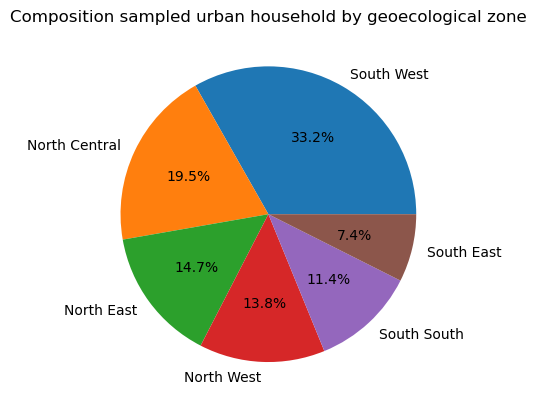

In [21]:
# Distribution of dataset by zone
# Plot a pie chart to show the composition of the data by state

# Get pie chart labels
labels = df2["zone"].value_counts().index.to_numpy()

# Get the pie chart values
values = df2["zone"].value_counts().values

# Create a pie chart of the number of people surveyed in each state
plt.pie(values, labels=labels, autopct="%1.1f%%")
plt.title("Composition sampled urban household by geoecological zone")
plt.show()

**Observation**:
* Majority (33.2%) of the sampled urban households are location in the South West Zone of the country.
* The least number of household are sampled from the South East.

**Impact**
* The representativeness of the sample from each zone is accounted for by the weight variable. This should be applied during analysis.

    


### **Household Characteristics**
In this section will we perform univariate analysis on the household variables. They include the following:

- household home ownership `hh_own_dwelling`
- agricultural land `hh_agricultural_land` and Agricultural land size category `hh_ag_land_size_cat`
- Livestock ownership `hh_own_animal`
- Livestock number `hh_ls_num`
- Source of water `water_source`
- Household size `hh_members_num`
- Number of women `num_of_women_15_49`
- Number of men `num_of_men_15_49`
- Number of child under 5 `num_under_5_child`
- Number of child over 5 `num_5_17_child`

##### Household own dwelling

<Axes: ylabel='Household home ownership'>

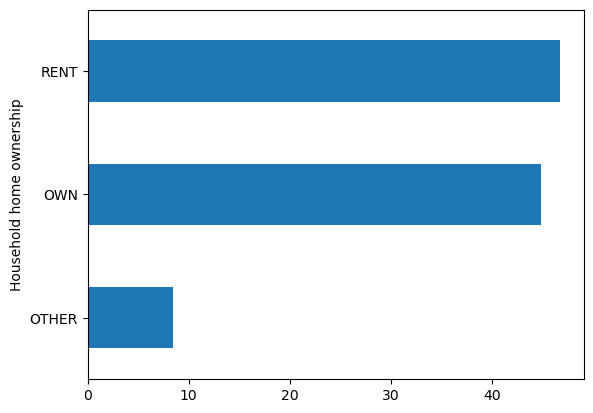

In [22]:
# Household own dwelling
(df2.hh_own_dwelling.value_counts(normalize=True)*100).sort_index().plot(kind="barh",
                                                                         ylabel="Household home ownership")


* The most common home dwelling arrangement in the urban houshold is 'rent'. However more than 40% of the sampled households have their own home.

##### Agricultural land ownership and size

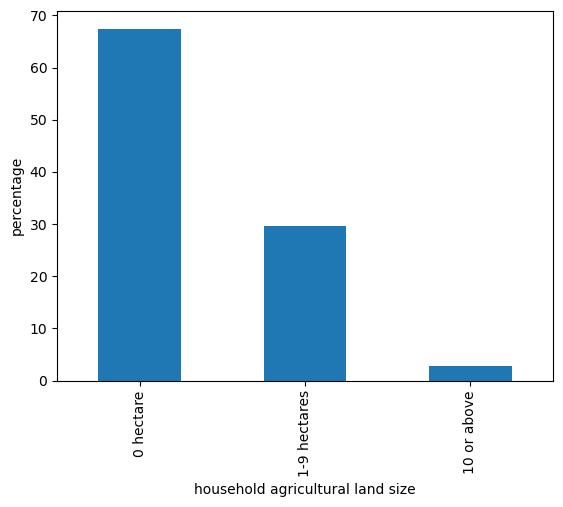

In [23]:
# What is the average size of land owned by the households?
(df2["hh_ag_land_size_cat"].value_counts(normalize=True)*100).plot(kind="bar", 
                                                                   xlabel="household agricultural land size",
                                                                   ylabel="percentage");

In [24]:

land_ownership_ratios = df2["hh_agricultural_land"].value_counts(normalize=True).sort_index(ascending=False)
land_ownership_ratios

hh_agricultural_land
YES    0.331273
NO     0.668727
Name: proportion, dtype: float64

In [25]:
# Get slice of household with agricultural land only
hh_own_land = df2.query("hh_agricultural_land == 'YES'")

# Calculat the weighted slice(percentage) of households with agricultural land by land size
percent_land_size = eda_utils.calculate_weighted_percentage(hh_own_land, "hh_ag_land_size_cat", "hhweightmics")
percent_land_size

,hh_ag_land_size_cat,weighted_sum,percentage
0,0 hectare,96.107329,0.022
1,1-9 hectares,3937.018113,0.894
2,10 or above,368.358869,0.084


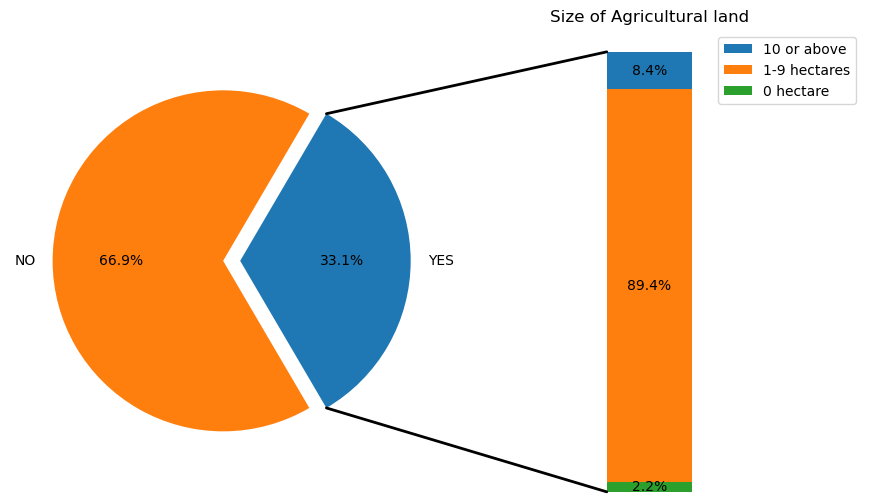

In [26]:
from utils import viz as viz_utils

viz_utils.plot_bar_of_pie(land_ownership_ratios, 
                          percent_land_size, 
                          "hh_ag_land_size_cat",
                          title="Size of Agricultural land")


**Observation**

* 33 percent of the urban households are agricultural land owners. 
* Of the households that own agricultural lands, 89.4% have land size that ranges from 1-9 hectares. 8.4% percent of households have 10 hectares and above.
* 2.2% reported they have 0 hectares. This seems like 'obnormal'/unlikely. However, we will ignore this for now.

It would be insightful to explore a bivariate analysis of with `zone`. Does houshold in the northern part of the country own my land compared to other parts of the country?

The plot below reveals our find:


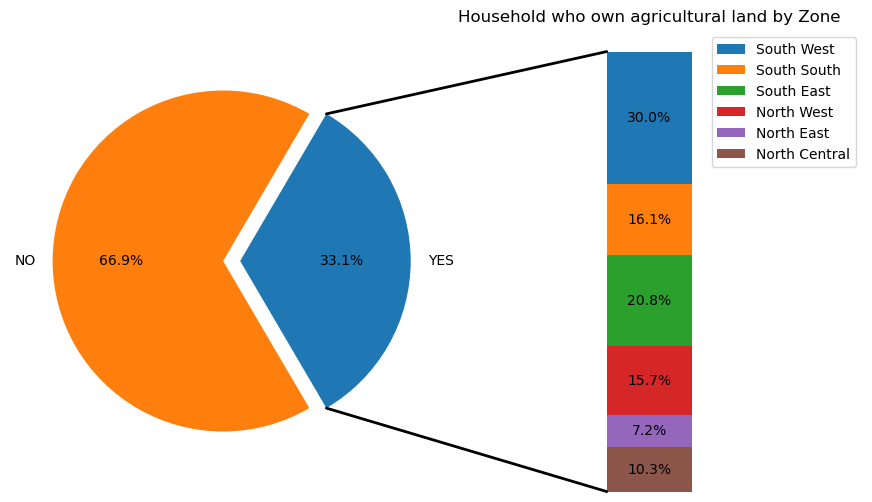

In [27]:
# Get slice of household with agricultural land only
hh_own_land = df2.query("hh_agricultural_land == 'YES'")

# Calculat the weighted slice(percentage) of households with agricultural land by zone
percent_land_by_zone = eda_utils.calculate_weighted_percentage(hh_own_land, "zone", "hhweightmics")
percent_land_by_zone = eda_utils.calculate_weighted_percentage(hh_own_land, "zone", "hhweightmics")


viz_utils.plot_bar_of_pie(land_ownership_ratios, 
                          percent_land_by_zone, 
                          "zone",
                          title="Household who own agricultural land by Zone")

* Household from Southwest and South South have have own agricultural land compared to other zones.
* Only 10.3 percent of the Households from the North Central, own agricultural land.

##### Household Livestock
The variables related to household livestock are: `hh_ls_num` and `hh_own_animal`

<Axes: xlabel='households that own animal', ylabel='percentage'>

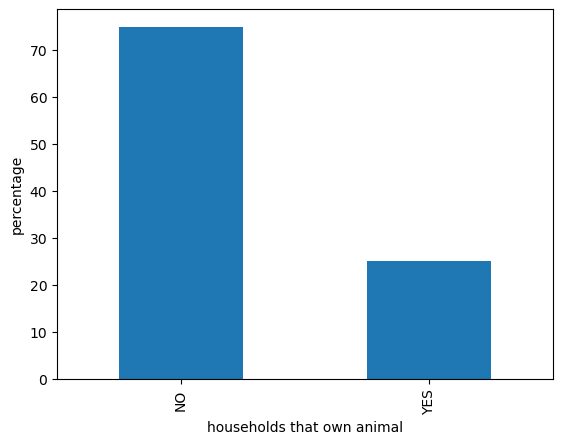

In [28]:
(df2.hh_own_animal.value_counts(normalize=True)*100).plot(kind="bar", xlabel="households that own animal", ylabel="percentage")

In [29]:
print(df2[df2["hh_own_animal"]=="YES"].hh_ls_num.describe())

count    2676.000000
mean       16.501868
std        22.635618
min         1.000000
25%         4.000000
50%         9.000000
75%        20.000000
max       370.000000
Name: hh_ls_num, dtype: float64


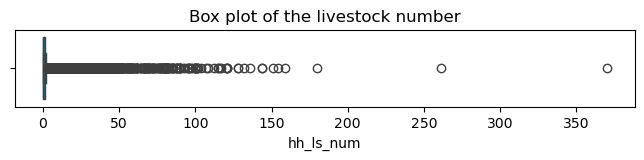

In [30]:
plt.figure(figsize=(8,1))
sns.boxplot(x="hh_ls_num",data=df2)
plt.title("Box plot of the livestock number");

* We can obserse some extreme values. For example, the maximum value of animal is above 300. This an outlier compared to the other records. 
Should handle this outlier. 

**Handle Outlier**
* Based on IQR
* Based on zscore

In [31]:
df2 = eda_utils.outlier_infor_iqr(df2,"hh_ls_num")
df2 = eda_utils.outlier_info_zscore(df2,"hh_ls_num")


Outliers records using IQR:
2272
Outliers records using ZSCORE:
313


* We note that there are actually fewer outliers defined with ZSCORE as using the 1.5 x IQR (Tukey) method. Why is this? The reason for this is that both Tukey’s and the standard score methods assume our data are normally distributed, when in fact they are skewed..Since the data don’t fit the assumptions of the methods we used, we get unexpected results.

Text(0.5, 1.0, 'Boxplot of Livstock Number (zcore)')

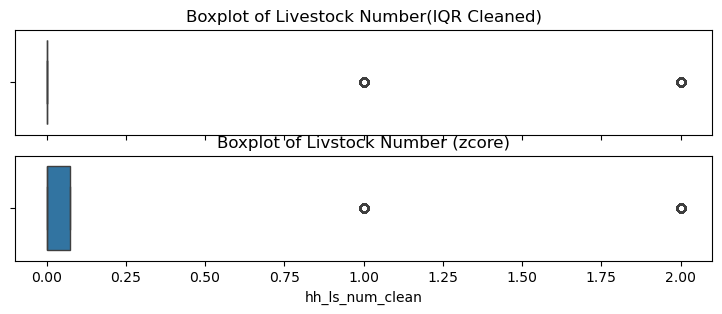

In [32]:
# Plot the distribution of the cleaned variable


fig, axes = plt.subplots(2,1, figsize=(9, 3), sharex=True)
sns.boxplot(df2, x="hh_ls_num_clean_iqr", ax=axes[0])
sns.boxplot(df2, x="hh_ls_num_clean", ax=axes[1])

# Set titles for the subplots
axes[0].set_title("Boxplot of Livestock Number(IQR Cleaned)")
axes[1].set_title("Boxplot of Livstock Number (zcore)")

Let’s generate a box plot of the entire data set, organized by some categorical variables.

/var/folders/v2/zgr5gbws4qd_qpb553947v7h0000gn/T/ipykernel_24060/109791210.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 1].set_xticklabels(['NC', 'NE', 'NW', 'SE', 'SS', 'SW'], ha='right')


<Axes: xlabel='urban_wi_quintile_mics', ylabel='hh_ls_num'>

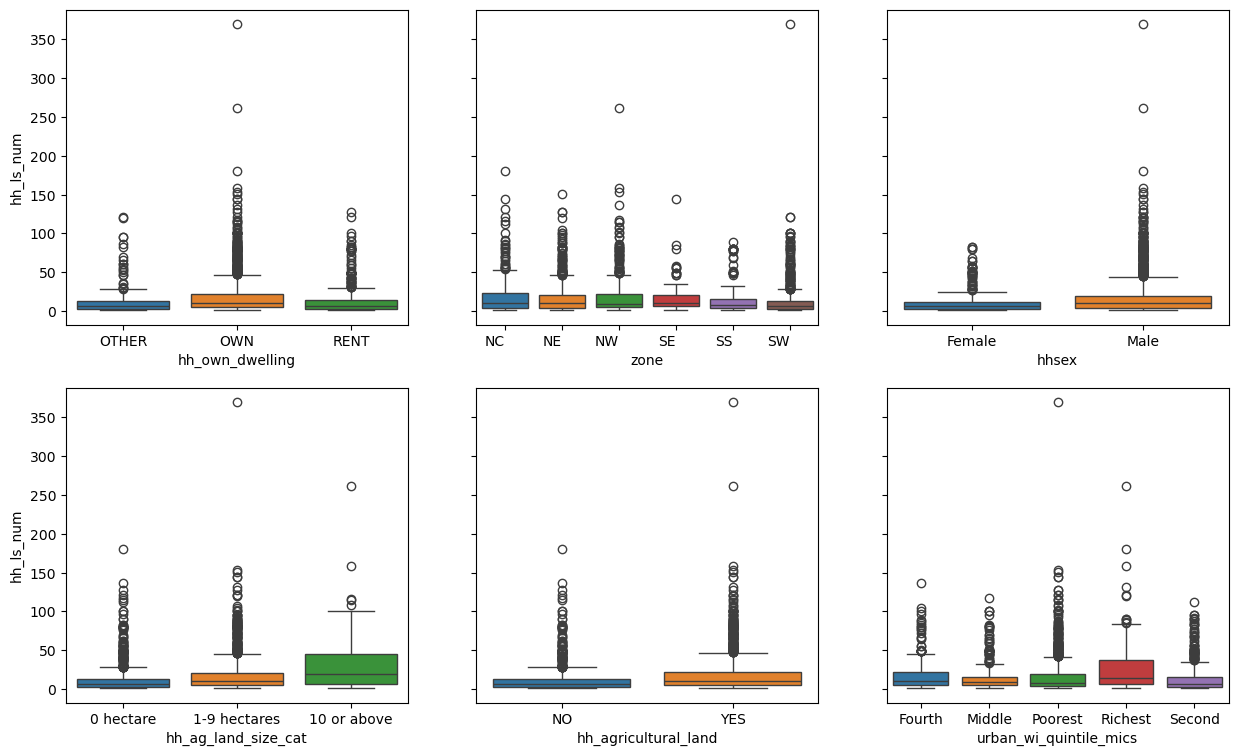

In [33]:

fig, axs = plt.subplots(2,3, figsize=(15, 9), sharey=True)

data_ls = df2[df2["hh_own_animal"]=="YES"].copy()

sns.boxplot(y="hh_ls_num", x="hh_own_dwelling", data=data_ls, hue="hh_own_dwelling", ax=axs[0, 0])
sns.boxplot(y="hh_ls_num", x="zone", data=data_ls, hue="zone", ax=axs[0, 1])
axs[0, 1].set_xticklabels(['NC', 'NE', 'NW', 'SE', 'SS', 'SW'], ha='right')
sns.boxplot(y="hh_ls_num", x="hhsex", data=data_ls, hue="hhsex", ax=axs[0, 2])
sns.boxplot(y="hh_ls_num", x="hh_ag_land_size_cat", data=data_ls, hue="hh_ag_land_size_cat", ax=axs[1, 0])
sns.boxplot(y="hh_ls_num", x="hh_agricultural_land", data=data_ls, hue="hh_agricultural_land", ax=axs[1, 1])
sns.boxplot(y="hh_ls_num", x="urban_wi_quintile_mics", data=data_ls, hue="urban_wi_quintile_mics", ax=axs[1, 2])



* Let’s also look at the distribution of values with a kernel density estimate:

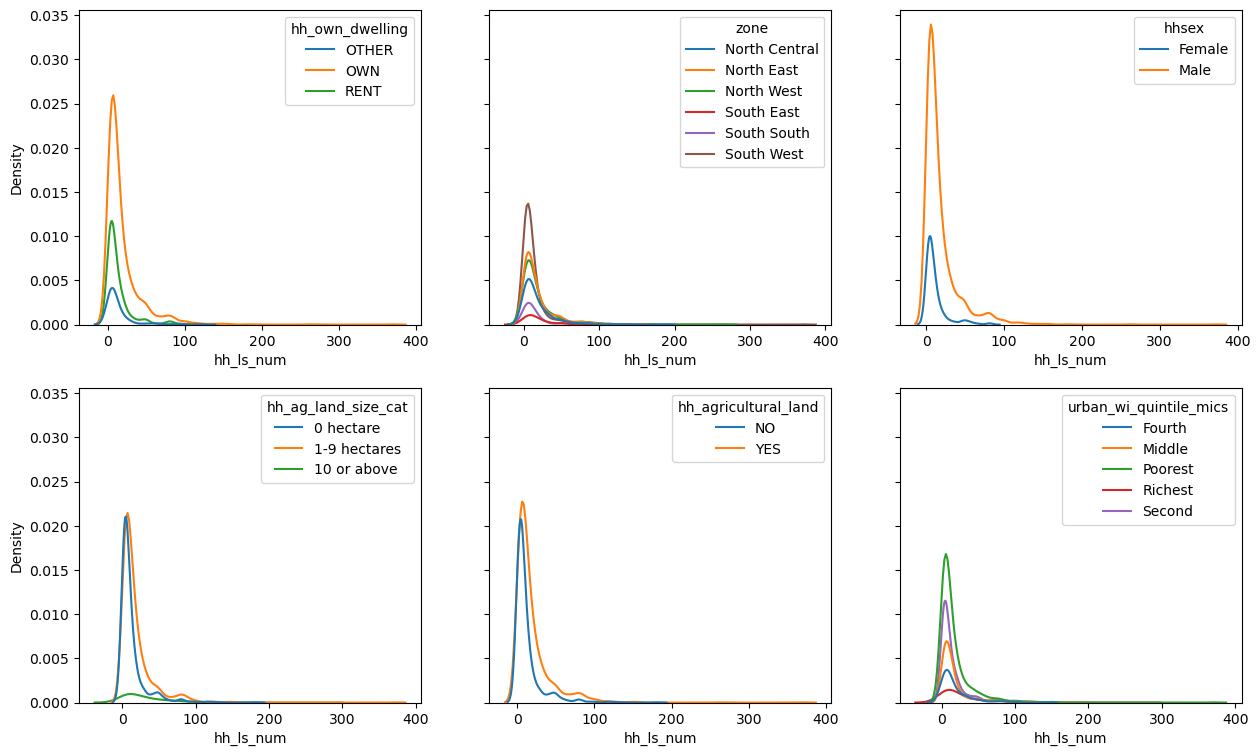

In [34]:
fig, axs = plt.subplots(2,3, figsize=(15, 9), sharey=True)

# data_ls = df2[df2["hh_own_animal"]=="YES"].copy()

sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_own_dwelling", ax=axs[0, 0])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="zone", ax=axs[0, 1])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hhsex", ax=axs[0, 2])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_ag_land_size_cat", ax=axs[1, 0])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="hh_agricultural_land", ax=axs[1, 1])
sns.kdeplot(x="hh_ls_num", data=data_ls, hue="urban_wi_quintile_mics", ax=axs[1, 2])
plt.show()


* Households that own their dwellings (OWN) have a higher density of livestock numbers compared to those who rent (RENT) or have other types of dwelling ownership (OTHER). This indicates that owning a dwelling might be associated with higher livestock ownership.
* All zones show a similar pattern with the highest density at low livestock numbers, indicating that small-scale livestock ownership is common across all zones. There isn’t a significant difference in the livestock distribution among the zones.
* Households headed by males (Male) have a higher density of livestock numbers compared to those headed by females (Female). This suggests that male-headed households might own more livestock.
* Households with agricultural land sizes between 1-9 hectares have the highest density of livestock numbers, followed by those with 0 hectare and 10 or above. This suggests that small to medium-sized landowners are more likely to own livestock.
*  Households with agricultural land (YES) have a slightly higher density of livestock numbers compared to those without (NO). This indicates that owning agricultural land is positively associated with livestock ownership.
* The Poorest wealth quintile shows the highest density of livestock numbers, followed by Second, Middle, Fourth, and Richest. This suggests that poorer households might rely more on livestock as a source of livelihood.

##### Household Member Size `hh_members_num`

In [35]:
df2["hh_members_num"].describe()

count    10680.000000
mean         4.977715
std          3.316338
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         31.000000
Name: hh_members_num, dtype: float64

<Axes: xlabel='hh_members_num'>

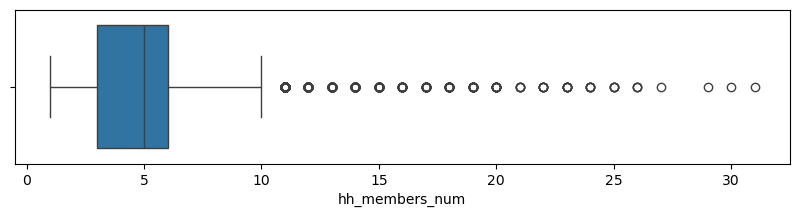

In [36]:
plt.figure(figsize=(10,2))
sns.boxplot(df2, x="hh_members_num")

* There are at least 4 members in each household.
* The number of household members ranges from 1 to 31. This doesn't appear to be abnormal.As this might include members from extended families.
* The boxplot shows that household with members greater than 10 are considered to be outliers. Should we decide to handle this outliers?

**Handle Outlier**

* Based on the IQR, `outlier_infor_iqr()`
* Based on standard z-score: `outlier_info_zscore()`


In [37]:
df2 = eda_utils.outlier_infor_iqr(df2, "hh_members_num")
df2 = eda_utils.outlier_info_zscore(df2, "hh_members_num", z_thresh=2.5)


Outliers records using IQR:
602
Outliers records using ZSCORE:
279


* We note that there are actually fewer outliers defined with ZSCORE as using the 1.5 x IQR (Tukey) method. Why is this? The reason for this is that both Tukey’s and the standard score methods assume our data are normally distributed, when in fact they are skewed..Since the data don’t fit the assumptions of the methods we used, we get unexpected results.

Text(0.5, 1.0, 'Boxplot of Household Members (zcore)')

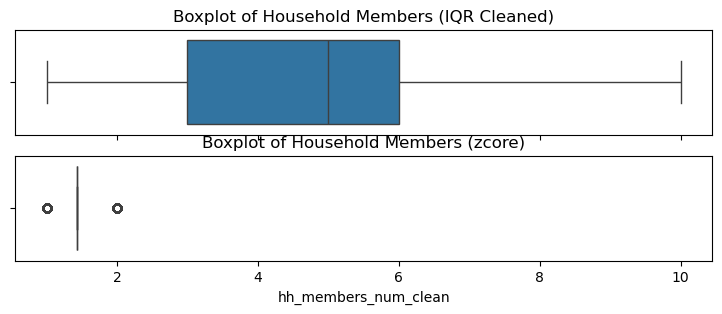

In [38]:
# Plot the distribution of the cleaned variable
fig, axes = plt.subplots(2,1, figsize=(9, 3), sharex=True)
sns.boxplot(df2, x="hh_members_num_clean_iqr", ax=axes[0])
sns.boxplot(df2, x="hh_members_num_clean", ax=axes[1])

# Set titles for the subplots
axes[0].set_title("Boxplot of Household Members (IQR Cleaned)")
axes[1].set_title("Boxplot of Household Members (zcore)")

In [39]:
df2.shape


(10680, 47)

In [40]:
df2.water_source.value_counts(dropna=False)

water_source
TUBE WELL / BOREHOLE                                                         4588
PACKAGED WATER: SACHET WATER                                                 1943
DUG WELL: PROTECTED WELL                                                     1411
PIPED WATER: PIPED INTO DWELLING                                              464
DUG WELL: UNPROTECTED WELL                                                    398
PIPED WATER: PUBLIC TAP / STANDPIPE                                           389
RAINWATER                                                                     224
CART WITH SMALL TANK                                                          216
PIPED WATER: PIPED TO YARD / PLOT                                             203
TANKER-TRUCK                                                                  186
PIPED WATER: PIPED TO NEIGHBOUR                                               163
PACKAGED WATER: BOTTLED WATER                                                 153
SUR

In [41]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,4.0,1.43299
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,2.0,2.00000
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,0.0,0.074929,5.0,1.43299
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,0.0,0.074929,4.0,1.43299
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,5.0,1.43299


### **Household Head Characteristics**
In this section will we perform univariate analysis on the household head variables. They include the following:

- Gender `hhsex`
- Age `hhage`
- Educational Attainment `helevel`

##### Household Gender

In [42]:
df2.hhsex.value_counts(normalize=True)*100


hhsex
Male      79.11985
Female    20.88015
Name: proportion, dtype: float64

In [43]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,4.0,1.43299
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,2.0,2.00000
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,0.0,0.074929,5.0,1.43299
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,0.0,0.074929,4.0,1.43299
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,5.0,1.43299


### **Food Insecurity Experience Scale (FIES) of Urban Household**

We already performed the [statistical validation ](notebooks/2_rasch_model_urban.ipynb) needed to ensure that the collected data is appropiate to measure comparable food insecurity.

Based on the FIES questions, we adopt several approaches to measure food insecurity. 

1. First, we use the raw values of the responses and associated “raw score” which we generate by summing the responses to the eight questions. The raw value of these responses assumes binary nature while the raw score assumes a value between zero and eight. By this definition, those households reporting experience of food insecurity across one or more of the eight dimensions are assumed to be facing food insecurity.

2. Households’ classification into **moderate or severe insecurity**(`FI_mod_sev`) follows the parametric analysis and procedure outlined by FAO and using the analytical tool: [https://fies.shinyapps.io/ExtendedApp/](https://fies.shinyapps.io/ExtendedApp/). This tool categorizes households’ food insecurity status based on severity of food insecurity experience.


#### **Composition of the `fies_rawscore`**


Raw score is ordinal (probabilistically) with respect to the latent trait of food insecurity. As such, it can be used to classify households within a country as to food insecurity status. (Such classification may not represent equal levels of severity between countries, however.) Raw score is NOT an interval measure, so it should *not be used to calculate a mean or in linear regression models*

The possible responses in each question in the FIES include “Yes” scored as 1, “No” scored as 0 and “Don’t know” scored as DK. Raw house-
hold FI scores (0–8) were computed as the total number of affirmative responses.

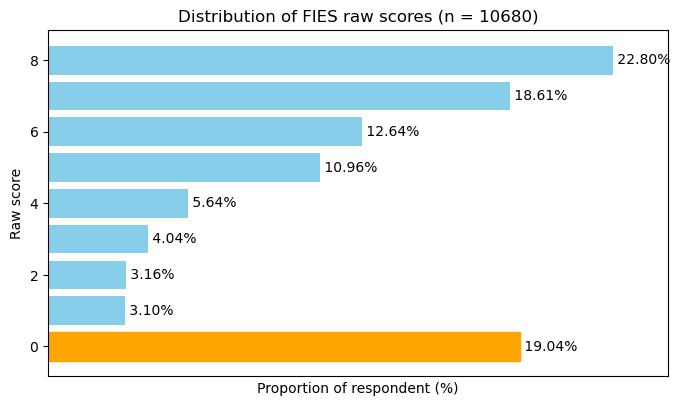

In [44]:
percent_fies_score = (df2["fies_score"].value_counts(normalize=True) * 100).sort_index()

plt.figure(figsize=(7,4))
ax = plt.barh(percent_fies_score.index, percent_fies_score, color='skyblue')

# Annotating the bars with count values
for i, v in enumerate(percent_fies_score):
    plt.text(v, i, f' {percent_fies_score.values[i]:.2f}%', va='center')

# Highlighting the bar with raw score value of 0
raw_score_0_index = percent_fies_score.index.get_loc(0)
ax[raw_score_0_index].set_color('orange')  

# Adding more space around the plot
plt.tight_layout()
plt.title(f"Distribution of FIES raw scores (n = {len(df2["fies_score"])})")
plt.xlabel("Proportion of respondent (%)")
plt.ylabel("Raw score")
plt.xlim((0, 25))
# plt.grid(True, axis="x")
plt.xticks([], []);

* Valid FIES question/response: 10,680, Minimum: 0 Maximum: 8
* The figure show the distribution of the raw scores in our data:
> * 19.04% respondents had a raw score of 0. ie, they did not experience any of the assessed recent food insecurity(RFI). In the framework of the FIES they are considered **Food Secure**.

**Impact**

* Recent food insecurity (RFI) is defined by a raw score greater than 0, meaning that at least one of the eight FIES questions had been answered with YES.




#### 1. **FIES Variables Based on Rawscore Approach**

For Classification Model Purpose, participants can be categorized into three levels of FI based on their scores. [Sheikomar OB, Dean W, Ghattas H, Sahyoun NR. Validity of the FI Experience Scale (FIES) for Use in League of Arab States (LAS) and Characteristics of Food Insecure Individuals by the Human Develop- ment Index (HDI). Curr Dev Nutr. 2021; 5(4):nzab017](https://pubmed.ncbi.nlm.nih.gov/30191202/). 
* 0 to 3 indicate **food secure**, 
* scores ranging from 4 to 6 indicate **moderate FI**, and 
* scores ranging from 7 to 8 indicate **severe FI**

Additionally, **[FAO](https://www.fao.org/3/bp091e/bp091e.pdf) suggested the following thresholds for Binary Classification:**
* Raw score 1 or greater versus raw score 0 ( Value of 1 for those households experiencing one or more form of food insecurity and 0 otherwise, based on the raw FIES score.)
* Raw score 4 or greater versus raw score 0-3 (On average, this corresponds
  approximately to moderately-or-severely food insecure versus secure-or-only-mildly insecure.)
* Raw score 7 or 8 versus raw score 0-6 (On average, this corresponds approximately to severely food insecure versus all others.)


In [45]:
# fies_3_levels ==["0-3", "4-6", "7-8"] -> ["food secure", "moderate fi", "severe fi"]
# fies_0_3 ==> ["0-3", "4-8"] -> [fi_secure_midly_insecure, "fi_mod_sev", ]
# fies_0_6 ==> ["0-6", "7-8"] -> [fi_secure_moderate_insecure, "fi_mod_sev", ]

df2 = df2.assign(
    fies_0_1 = pd.cut(df2["fies_score"], bins=[0,1, float("inf")], labels=["0", ">1"], right=False),
    fies_0_3 = pd.cut(df2["fies_score"], bins=[0,4, float("inf")], labels=["0-3", "4-8"], right=False),
    fies_0_6 = pd.cut(df2["fies_score"], bins=[0,7, float("inf")], labels=["0-6", "7-8"], right=False),
    fies_0_3_7 = pd.cut(df2["fies_score"], bins=[0,4,7, float("inf")], labels=["0-3", "4-6", "7-8"], right=False),
)

In [46]:
# Sanity check of the datatype of the new variables
df2[["fies_score","fies_0_3_7", "fies_0_3", "fies_0_6"]].info()

<class 'pandas.core.frame.DataFrame'>
Index: 10680 entries, 0 to 33491
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   fies_score  10680 non-null  int64   
 1   fies_0_3_7  10680 non-null  category
 2   fies_0_3    10680 non-null  category
 3   fies_0_6    10680 non-null  category
dtypes: category(3), int64(1)
memory usage: 198.5 KB



**Impact**

Based on these approaches, we end up with four sets of food insecurity indicators: 

* raw responses to each of the eight questions 
* `fies_score`: raw score across the eight questions
* `fies_0_1`: Binary indicator of experience of food insecurity (assuming a value of 1 for those households with raw score above zero and 0 otherwise)
* `fies_0_3`: Binary indicator of FIES  (assuming a value of 1 for those household with raw score above 3 and 0 otherwise) 
*  `fies_0_6`: Binary indicator of FIES  (assuming a value of 1 for those household with raw score 7-8 and 0 otherwise)
*  `fies_0_3_7`: Multpiple indicator of FIES assuming raw score
      - 0 to 3 ==> indicate food secure,
      - 4 to 6 ==> indicate moderate FI,
      - 7 to 8 ==> severe FI



#### 2. **Probabibility of Food Insecurity**
**Food insecurity metric based on responses provided to each of the FIES questions**

To achieve precise comparability of prevalence rates of food insecurity, we used the respondent parameter produced by the **Rasch model** which contains the probability of **moderate-or-severe** (`FI_mod_sev`) and **severe** (`FI_sev`) food insecurity for a respondent with each of the nine possible raw scores (0-8).



**Generate Respondent-level model based food insecurity**

Generating respondent-level, modelbased food insecurity indicators. This analysis generates
several important indicators of food insecurity including: 

* raw score, 
* severity of food insecurity, 
* probability of moderate or severe food insecurity,
* probability of severe food insecurity. 

In [47]:
df2.groupby("fies_score")[["prob_mod_sev", "prob_sev"]].mean().reset_index()

,fies_score,prob_mod_sev,prob_sev
0,0,0.000,0.000
1,1,0.022,0.000
2,2,0.085,0.000
3,3,0.284,0.000
4,4,0.616,0.000
5,5,0.875,0.002
6,6,0.971,0.043
7,7,0.995,0.390
8,8,1.000,0.821


Create a binary indicator of experience of moderate or severe (`FI_mod_sev`) and severe (`FI_sev`) food insecurity based on probability of
food insecurity. Assuming:

* `FI_mod_sev`: 1 if `prob_mod_sev` is greated than zero, 0 otherwise.
* `FI_sev`: 1 if `prob_sev` is greated than zero, 0 otherwise.

In [48]:
df2 = df2.assign(
    FI_mod_sev = np.where(df2["prob_mod_sev"] > 0.0, 1, 0),
    FI_sev = np.where(df2["prob_sev"] > 0.0, 1, 0)
    
)
df2.shape

(10680, 53)

**Impact**

Based on this approach, we end up with 2 sets of food insecurity indicators: 

* `FI_mod_sev`: a binary indicator of experience of moderate or severe food insecurity based on severity of food insecurity


##### Urban Household Probability of Moderate or Severe and Severe Food Insecurity

In [49]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,fies_0_1,fies_0_3,fies_0_6,fies_0_3_7,FI_mod_sev,FI_sev
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,4.0,1.43299,>1,4-8,7-8,7-8,1,1
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,2.0,2.00000,>1,4-8,0-6,4-6,1,1
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,0.0,0.074929,5.0,1.43299,>1,4-8,0-6,4-6,1,1
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,0.0,0.074929,4.0,1.43299,>1,4-8,7-8,7-8,1,1
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,5.0,1.43299,>1,4-8,7-8,7-8,1,1


In [50]:

weight_sum_prob_mod_sev = df2["prob_mod_sev"].mean()
weight_sum_prob_sev = df2["prob_sev"].mean()

print(f" Recent Moderate or severe food insecurity: {weight_sum_prob_mod_sev}")
print(f" Recent Severe food insecurity: {weight_sum_prob_sev}")

 Recent Moderate or severe food insecurity: 0.681458988764045
 Recent Severe food insecurity: 0.26543511235955053


**Observation**

* According to the FIES, 68.09 percent of the households in urban are were affected by RFI at moderate or
severe level, and 26.47 percent were affected by severe RFI.



**Impact**
* This value is similar to what is obtained from [FIES Shiny App]( https://fies.shinyapps.io/ExtendedApp/). Likewise the result from using `R.weight` methods

In [51]:
# chi_square_test from utils module
eda_utils.chi_square_test(df2, "zone")


{'P-value FI_sev': 1.3673803344436952e-10,
 'P-value FI_mod_sev': 1.911196688743079e-14}

##### **By Household Gender**

In [52]:
# Utitily function to conduction Bivariate Analysis
# Btw probability of respondent ebeing moderate or severe level
# and severe level of food insecurity
def aggregate_fies_prob_values(df, col):
    """
    Aggregate the `fies_prob_value` column by specified group columns using the specified aggregation function.

    Parameters
    ----------
    df : pandas.DataFrame
        The DataFrame containing the data.
    col : str
        The column name to aggregate, e.g., 'zone'.

    Returns
    -------
    pandas.DataFrame
        A DataFrame with the aggregated results.
    """

    # Melt the DataFrame
    melted_df = pd.melt(
        df,
        id_vars=[col],
        value_vars=["prob_mod_sev", "prob_sev"],
        var_name="RFI_level",
        value_name="prob_value",
    )

    # Compute the aggregate by zone and RFI_level
    aggregate_df = (melted_df.groupby([col, "RFI_level"], observed=True)["prob_value"].mean()*100).reset_index()
    
    return aggregate_df

==========Sample Result by Household Gender===========
RFI_level  prob_mod_sev   prob_sev
hhsex                             
Female        70.052063  27.874305
Male          67.642852  26.192308


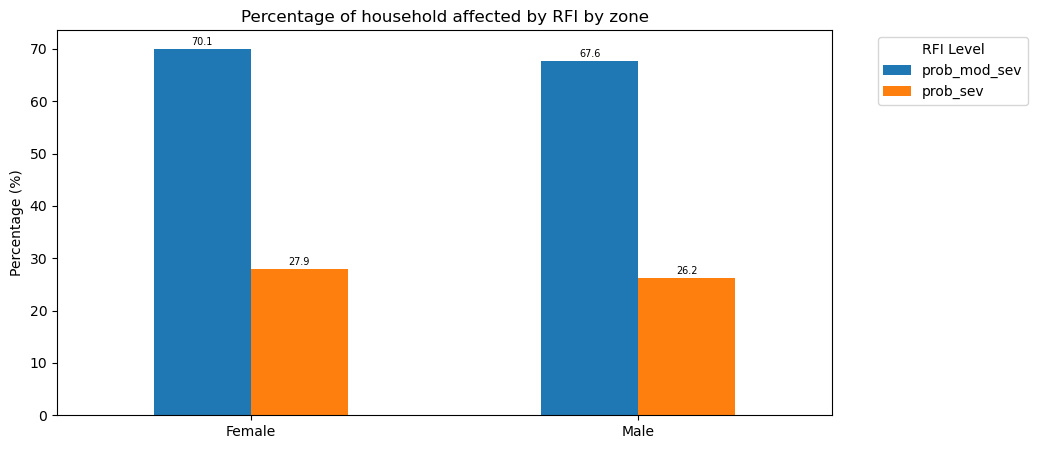

{'P-value FI_sev': 0.01156871369062968,
 'P-value FI_mod_sev': 0.7524456725714339}

In [53]:
fies_agg_by_hhsex = aggregate_fies_prob_values(df2, "hhsex")
# Group by state and RFI_level, then sum the percentages
hhsex_result = fies_agg_by_hhsex.groupby(["hhsex", "RFI_level"], observed=True)["prob_value"].mean().unstack()

print("==========Sample Result by Household Gender===========")
print(hhsex_result)
eda_utils.plot_fies_levels_by_vars(hhsex_result,
                         figsize=(10,5), 
                         title="Percentage of household affected by RFI by zone"
                        )

eda_utils.chi_square_test(df2, "hhsex")


* The level of FIES moderate or severe, and severe were higher for urban female-headed households compared to urban male-headed households.
*

Is this difference significant?

* Level of severe food insecurity for female is higher and difference is statistically significant

##### By Household Own Dwelling

==========Sample Result by Household Own Dwelling===========
RFI_level        prob_mod_sev   prob_sev
hh_own_dwelling                         
OTHER               69.468562  26.111817
OWN                 64.359253  25.313332
RENT                71.545291  27.802725


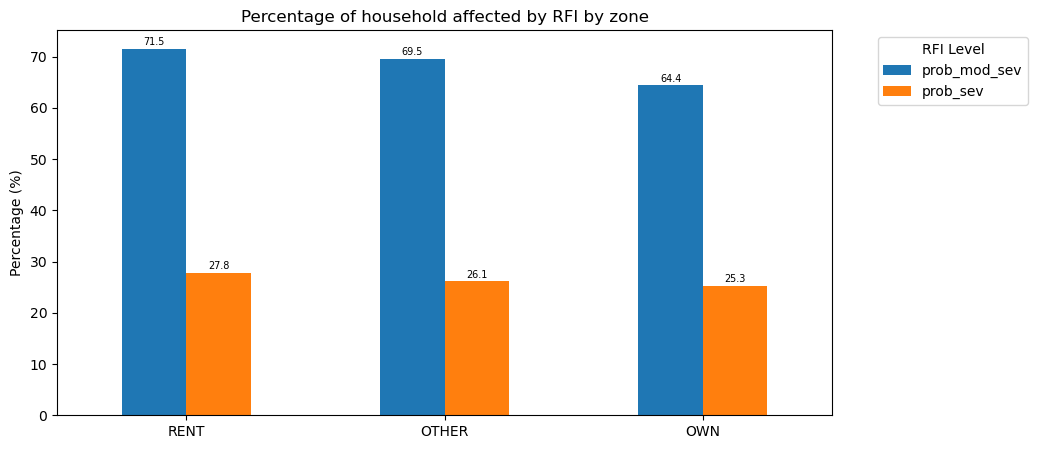


==========Is the difference significant +==========


{'P-value FI_sev': 7.96613792309814e-16,
 'P-value FI_mod_sev': 3.569173451016627e-08}

In [54]:
fies_agg_by_own_dwelling = aggregate_fies_prob_values(df2, "hh_own_dwelling")
# Group by state and RFI_level, then sum the percentages
own_dwelling_result = fies_agg_by_own_dwelling.groupby(["hh_own_dwelling", "RFI_level"], observed=True)["prob_value"].mean().unstack()

print("==========Sample Result by Household Own Dwelling===========")
print(own_dwelling_result)
eda_utils.plot_fies_levels_by_vars(own_dwelling_result,
                         figsize=(10,5), 
                         title="Percentage of household affected by RFI by zone"
                        )

# Check if the differences is significant
print("\n==========Is the difference significant +==========")
eda_utils.chi_square_test(df2, "hh_own_dwelling")

* Households whose dwelling is 'RENT' presented a higher level of FIES moderate or severe and severe. And the difference is significant

##### **By Zone**

==========Sample Result by Zone===========
RFI_level      prob_mod_sev   prob_sev
zone                                  
North Central     71.212991  26.184276
North East        65.586790  30.296171
North West        67.262491  26.668958
South East        76.316793  26.994823
South South       70.265107  25.114860
South West        65.287204  25.435090


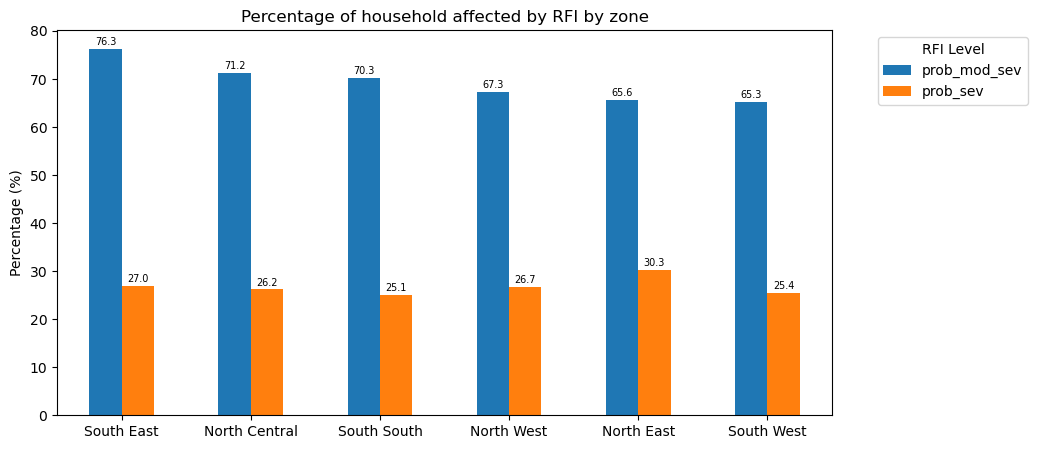


==========Is the difference significant +==========


{'P-value FI_sev': 1.3673803344436952e-10,
 'P-value FI_mod_sev': 1.911196688743079e-14}

In [142]:
fies_agg_by_zone = aggregate_fies_prob_values(df2, "zone")
# Group by state and RFI_level, then sum the percentages
zone_result = fies_agg_by_zone.groupby(["zone", "RFI_level"], observed=True)["prob_value"].mean().unstack()

print("==========Sample Result by Zone===========")
print(zone_result)
eda_utils.plot_fies_levels_by_vars(zone_result,
                         figsize=(10,5), 
                         title="Percentage of household affected by RFI by zone"
                        )

# Check if the differences is significant
print("\n==========Is the difference significant +==========")
eda_utils.chi_square_test(df2, "zone")

* South East presents the highest percentage(76.3%) of urban households affected by RFI at moderate or severe level.
* South West presents the lowest percentage of urban household affected by RFI at moderate or severe level (65.3 percent)

Is the difference statistically significant? YES, from the p-values obtained from the chi test.


##### Map of Prevalence of Food Insecurity levels
Prevalence of recent moderate or severe household food insecurity (FIES) by zone


In [56]:
# Load shapefile of Nigeria
# file = open("../../../data/DIEM_NG/DIEM_household_surveys_microdata.geojson")
file = open("../assets/nigeria_geojson.geojson")


gdf = gpd.read_file(file)

In [57]:
gdf = gdf.rename(columns = {"geozone": "zone"})

gdf = gdf.replace({"NCZ": "North Central", "NWZ": "North West",
                   "SWZ": "South West", "SSZ": "South South",
                  "NEZ": "North East", "SEZ": "South East"})


In [58]:
fies_agg_by_zone

,zone,RFI_level,prob_value
0,North Central,prob_mod_sev,71.212991
1,North Central,prob_sev,26.184276
2,North East,prob_mod_sev,65.586790
3,North East,prob_sev,30.296171
4,North West,prob_mod_sev,67.262491
5,North West,prob_sev,26.668958
6,South East,prob_mod_sev,76.316793
7,South East,prob_sev,26.994823
8,South South,prob_mod_sev,70.265107
9,South South,prob_sev,25.114860


In [59]:
# Merge the shapefile with your data
map_data = gdf.merge(fies_agg_by_zone, how="left", on="zone")
map_data = map_data.query("RFI_level == 'prob_mod_sev'")

# Categorize the `prob_value` into binary variables
map_data['prob_value2'] = map_data['prob_value'].apply(lambda x: '60-70%' if 60 <= x <= 70 else ('70-100%' if 70 < x <= 100 else x))


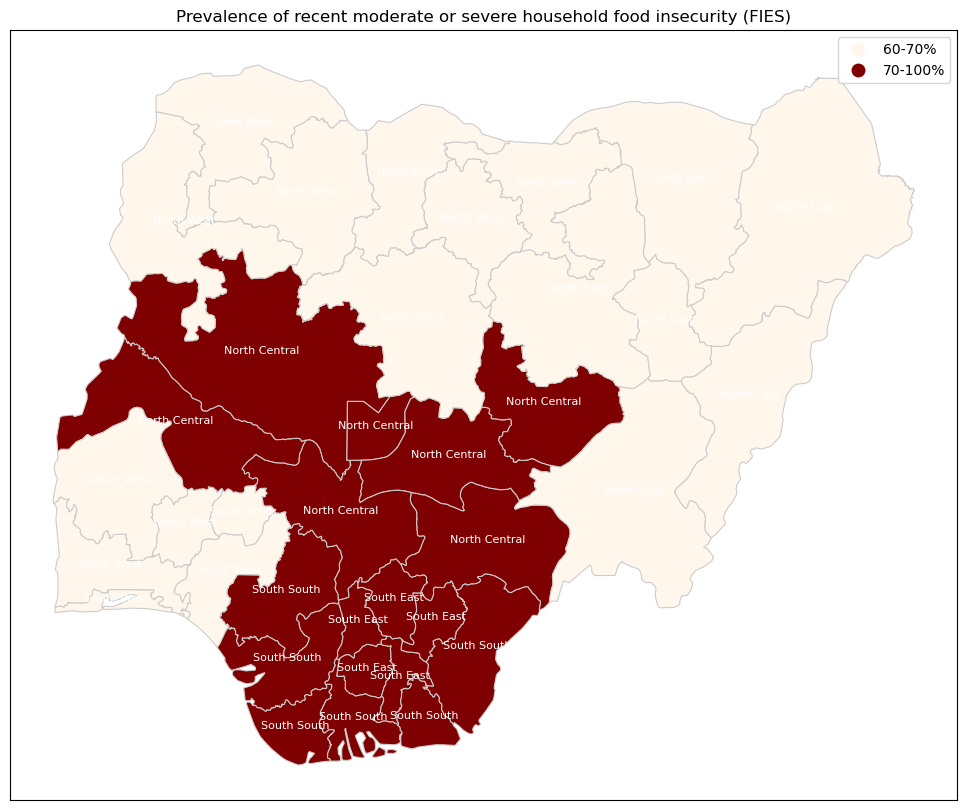

In [60]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
map_data.plot(column="prob_value2", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)



# Annotate each state with its name
for idx, row in map_data.iterrows():
    ax.annotate(text=row["zone"], 
                xy=(row.geometry.centroid.x, row.geometry.centroid.y), 
                color="white", fontsize=8, ha="center")


plt.title("Prevalence of recent moderate or severe household food insecurity (FIES)")
import matplotlib.patches as mpatches


plt.xticks([], [])
plt.yticks([], [])

plt.show()

* Household from the urban areas of North cental, South East and South South presents the highest percentage of households affected by moderate or sevel level of food insecurity.

#### **Weighted Affirmative Response FIES Items**
We already performed the weighted affirmative response of the food insecurity experience scale items in this notebook. [Affirmative Items](notebooks/2_rasch_model_urban.ipynb) 

In [61]:
fies_item_perc =  pd.read_csv("../processed_data/fies_item_parameter_statistics_urban.csv", index_col=0)

fies_item_perc.loc[:, ["Item", "Weighted.perc..of.Yes", "Unweighted.perc..of.Yes"]]

,Item,Weighted.perc..of.Yes,Unweighted.perc..of.Yes
1,WORRIED,0.76,0.76
2,HEALTHY,0.72,0.72
3,FEWFOOD,0.72,0.72
4,SKIPPED,0.65,0.64
5,ATELESS,0.69,0.69
6,RANOUT,0.57,0.57
7,HUNGRY,0.48,0.50
8,WHLDAY,0.26,0.29


##### Overall FIES Items Response

In [62]:
fies_questions = df2.loc[:, list(df2.loc[:, "WORRIED":"WHLDAY"].columns) + ["hhweightmics"]]

# Turn from wide to long data format
fies_long = pd.melt(fies_questions, id_vars=['hhweightmics'], var_name='Question', value_name='Response',)

cross_tab_prop = pd.crosstab(index=fies_long['Question'],
                             columns=fies_long['Response'],
                             normalize="index")

cross_tab_prop = cross_tab_prop.sort_values(by=1, ascending=False)
cross_tab= pd.crosstab(index=fies_long["Question"], columns=fies_long["Response"]).sort_values(by=1, ascending=False)


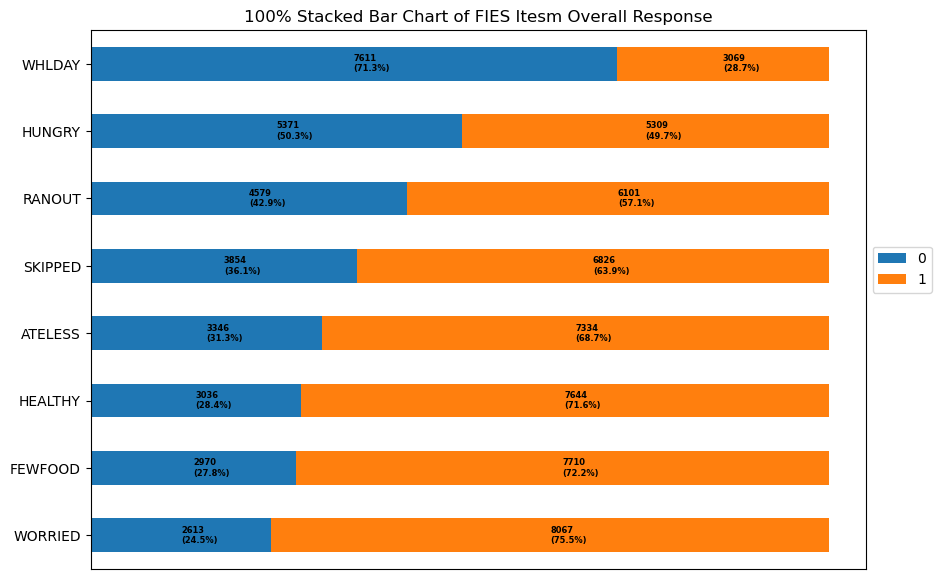

In [63]:
eda_utils.plot_fies_item_stacked_bar(cross_tab_prop, 
                                     cross_tab,
                                    title="100% Stacked Bar Chart of FIES Itesm Overall Response")


**Observation**

When looking at the distribution of affirmative answers to each FIES question we observe the following:

* The item `WHLDAY` has the lowest affirmative response (29%). This item has the highest severity, implies, of all the items, therefore, expected to received the fewest number of "YES" response.
* The item `WORRIED` have the highest affirmative response (76%).

##### Analysis of FIES Item by Zone
Number of affirmative response. ie. Yes responses

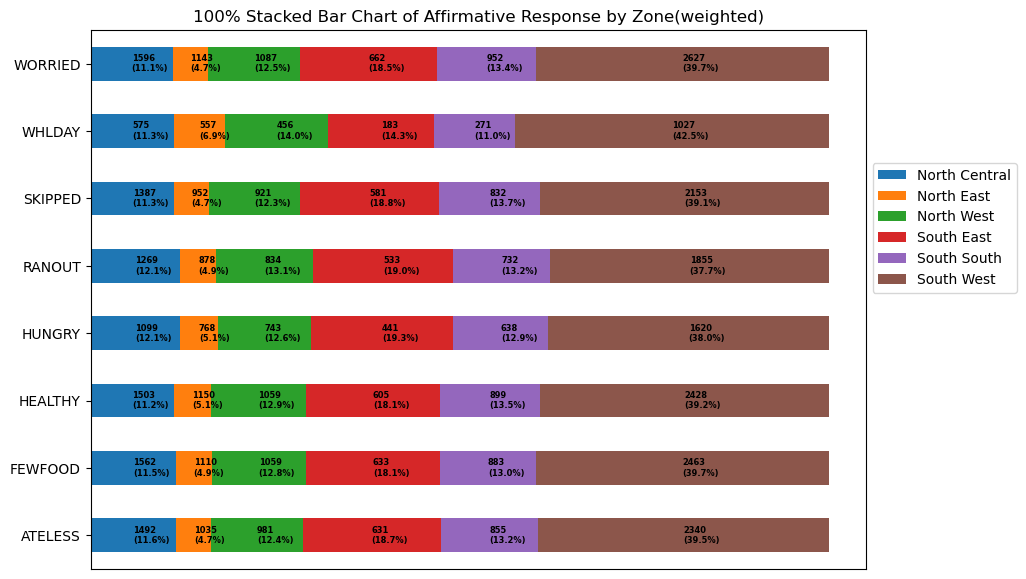

In [65]:
# Weighted relevance of each question (number of positive answers) in the different zones
fies_zone_prop, fies_zone_ = eda_utils.process_fies_question_data_wt(df2, col="zone")

# PLot the outcome
eda_utils.plot_fies_item_stacked_bar(fies_zone_prop, fies_zone_, title="100% Stacked Bar Chart of Affirmative Response by Zone(weighted)")

In [81]:
# Unweighted version.,...Analysis per location(zone)
fies_zone_prop = eda_utils.process_fies_question_data(df2, col="zone")[0]
fies_zone_ = eda_utils.process_fies_question_data(df2)[1]

# PLot the outcome
# eda_utils.plot_fies_item_stacked_bar(fies_zone_prop, fies_zone_, title="100% Stacked Bar Chart of Affirmative Response by Zone")


##### Analysis of FIES Items by Severe Level of Food insecurity

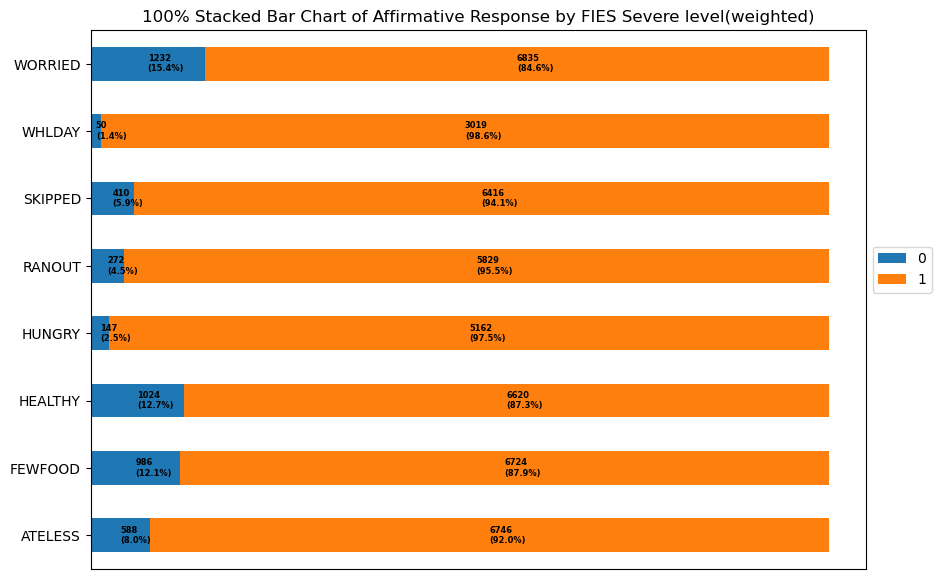

In [82]:
# Weighted relevance of each question (number of positive answers) in the different zones
FI_sev_prop, FI_sev = eda_utils.process_fies_question_data_wt(df2, col="FI_sev")

# PLot the outcome
eda_utils.plot_fies_item_stacked_bar(FI_sev_prop, FI_sev, 
                                     title="100% Stacked Bar Chart of Affirmative Response by FIES Severe level(weighted)")

##### Analysis of FIES Items by Severe Urban Household Weatlh Quintile

## Bivariate Analysis

In [139]:

# Household size (>=)
# Number of children in the household
# Number of men
# number of wowen
# Wealh index
# hh gender
# hh education
# FI_sev
df2.hh_members_num.describe()

count    10680.000000
mean         4.977715
std          3.316338
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max         31.000000
Name: hh_members_num, dtype: float64

### Feature Engineer some new variables
To gain an even deeper insight of the characteristics of the household, we proceed to create some new variables.

In [132]:
# =========== New Variables ======

# Adult household members size = num_of_women_15_49 + num_of_men_15_49
df2.assign(num_adults = df2["num_of_women_15_49"].add(df2["num_of_men_15_49"]),
          num_children = df2["num_under_5_child"].add(df2["num_5_17_child"]),
          hh_siz_cat = )

# Household size
# number of adults 
# number of children



,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,fies_0_1,fies_0_3,fies_0_6,fies_0_3_7,FI_mod_sev,FI_sev,num_adults
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.619550,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,4.0,1.43299,>1,4-8,7-8,7-8,1,1,3.0
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.619550,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,2.0,2.00000,>1,4-8,0-6,4-6,1,1,2.0
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.619550,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,0.0,0.074929,5.0,1.43299,>1,4-8,0-6,4-6,1,1,1.0
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.619550,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,0.0,0.074929,4.0,1.43299,>1,4-8,7-8,7-8,1,1,2.0
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.619550,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,5.0,1.43299,>1,4-8,7-8,7-8,1,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33487,1842.0,16.0,URBAN,North Central,7.0,1.0,0.0,1.0,3.0,Male,49.0,No Education,OWN,NO,YES,0.0,0.0,0.0,0.0,0.0,40.000000,0.0,10.000000,TUBE WELL / BOREHOLE,Middle,Second,10,4,0.406595,1842.0,37.0,0.616,0.000,4,1,1,1,0,1,0,0,0,0 hectare,0.0,0.074929,7.0,1.43299,>1,4-8,0-6,4-6,1,0,1.0
33488,1842.0,17.0,URBAN,North Central,8.0,1.0,1.0,1.0,5.0,Male,40.0,Junior secondary,OTHER,NO,NO,1.0,40.0,0.0,6.0,1.0,33.000000,0.0,7.000000,TUBE WELL / BOREHOLE,Middle,Poorest,0,6,0.406595,1842.0,37.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,8.0,1.43299,>1,4-8,0-6,4-6,1,1,2.0
33489,1842.0,18.0,URBAN,North Central,4.0,1.0,0.0,2.0,0.0,Male,35.0,Higher/tertiary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,22.000000,0.0,5.000000,TUBE WELL / BOREHOLE,Middle,Poorest,0,6,0.406595,1842.0,37.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,4.0,1.43299,>1,4-8,0-6,4-6,1,1,1.0
33490,1842.0,19.0,URBAN,North Central,5.0,1.0,1.0,1.0,2.0,Male,30.0,Primary,RENT,NO,NO,1.0,30.0,0.0,5.0,1.0,25.000000,0.0,7.000000,TUBE WELL / BOREHOLE,Second,Poorest,0,6,0.406595,1842.0,37.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,5.0,1.43299,>1,4-8,0-6,4-6,1,1,2.0


In [67]:
df2.head()

,hh1,hh2,area,zone,hh_members_num,num_of_women_15_49,num_of_men_15_49,num_under_5_child,num_5_17_child,hhsex,hhage,helevel,hh_own_dwelling,hh_agricultural_land,hh_own_animal,hh_mn_attended_sch_num,hh_mn_mean_age_yrs,hh_mn_attended_atleast_sec_sch,hh_mn_mean_life_satisfaction,hh_wm_attended_sch_num,hh_wm_mean_age_yrs,hh_wm_attended_atleast_sec_sch,hh_wm_mean_life_satisfaction,water_source,wi_quintile_mics,urban_wi_quintile_mics,hh_ls_num,fies_score,hhweightmics,psu,stratum,prob_mod_sev,prob_sev,rs_fies_score,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,hh_ag_land_size_cat,hh_ls_num_clean_iqr,hh_ls_num_clean,hh_members_num_clean_iqr,hh_members_num_clean,fies_0_1,fies_0_3,fies_0_6,fies_0_3_7,FI_mod_sev,FI_sev
0,1.0,1.0,URBAN,South East,4.0,3.0,0.0,0.0,1.0,Female,46.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,3.0,28.666667,2.0,3.333333,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,4.0,1.43299,>1,4-8,7-8,7-8,1,1
1,1.0,2.0,URBAN,South East,2.0,2.0,0.0,0.0,1.0,Female,45.0,Senior secondary,RENT,NO,NO,0.0,0.0,0.0,0.0,2.0,30.500000,2.0,5.500000,TUBE WELL / BOREHOLE,Fourth,Second,0,6,0.61955,1.0,1.0,0.971,0.043,6,1,1,1,1,1,1,0,0,0 hectare,0.0,0.000000,2.0,2.00000,>1,4-8,0-6,4-6,1,1
2,1.0,3.0,URBAN,South East,5.0,1.0,0.0,2.0,1.0,Male,41.0,Senior secondary,OWN,NO,YES,0.0,0.0,0.0,0.0,1.0,34.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,30,5,0.61955,1.0,1.0,0.875,0.002,5,1,0,0,1,1,1,1,0,0 hectare,0.0,0.074929,5.0,1.43299,>1,4-8,0-6,4-6,1,1
3,1.0,4.0,URBAN,South East,4.0,1.0,1.0,0.0,0.0,Male,81.0,No Education,OWN,YES,YES,1.0,33.0,1.0,5.0,1.0,38.000000,1.0,8.000000,TUBE WELL / BOREHOLE,Middle,Poorest,144,7,0.61955,1.0,1.0,0.995,0.390,7,0,1,1,1,1,1,1,1,1-9 hectares,0.0,0.074929,4.0,1.43299,>1,4-8,7-8,7-8,1,1
4,1.0,5.0,URBAN,South East,5.0,1.0,0.0,0.0,1.0,Male,63.0,Primary,RENT,NO,NO,0.0,0.0,0.0,0.0,1.0,23.000000,1.0,4.000000,TUBE WELL / BOREHOLE,Fourth,Middle,0,7,0.61955,1.0,1.0,0.995,0.390,7,1,1,1,1,1,1,1,0,0 hectare,0.0,0.000000,5.0,1.43299,>1,4-8,7-8,7-8,1,1


In [52]:
# ============Bivariate plot plots=========
# Prevalence of moderate and/or severe food insecurity among urban hh, by zone and household wealth index. 

# Prevalence of food insecurity among urban household, by zone and hh_agricultural_land

# Prevalence of food insecurity among urban household, by hh_agricultural_land and hh_ag_land_size_cat

# Prevalence of moderate or severe food insecurity by hh_own_dwelling and household member size

# Prevalence of moderate and/or severe food insecurity among urban household, by zone and gender of the head of household. 



# -=============Descritptives Tables ==========
#1 Estimated total number of houshold that are (i) moderately or severely food insecure and (ii) severely food insecure and 
#2 average incidence of (i) moderate or severe food insecurity and (ii) severe food insecurity among the urban household (by zone)
#Table 1: Summary of Food Insecurity Measures and Indicators. (weighted using the sampling weight).

# ==============Regressions=============
#3a. Prevalence of food insecurity by zone 
#4a. Prevalence of food insecurity by gender of household head and zone.
# Educational activity and foodinsecurity